In [2]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

In [136]:
# extract the frames from the mp4 file

# turns out to be too much noise on my floor

# def extract_frames(video_path, output_folder):
#     os.makedirs(output_folder, exist_ok=True)
#     vidcap = cv2.VideoCapture(video_path)
#     success,image = vidcap.read()
#     count = 0
#     while success:
#         cv2.imwrite(output_folder + "/frame%d.jpg" % count, image)     # save frame as JPEG file      
#         success,image = vidcap.read()
#         count += 1
#     print("Frames extracted successfully")
#     return count

# extract_frames("test.mp4", "images")

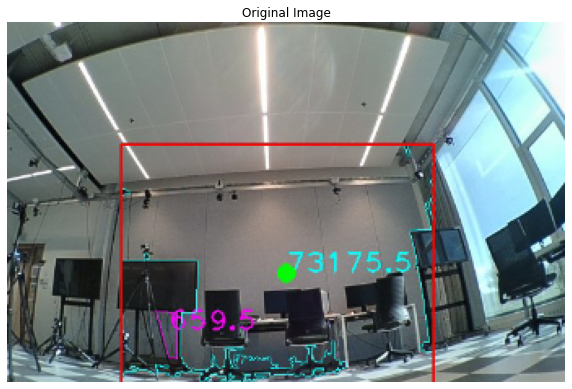

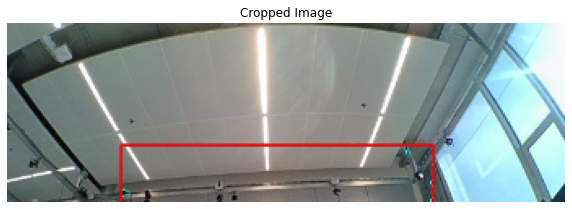

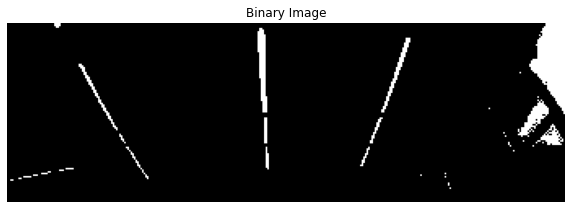

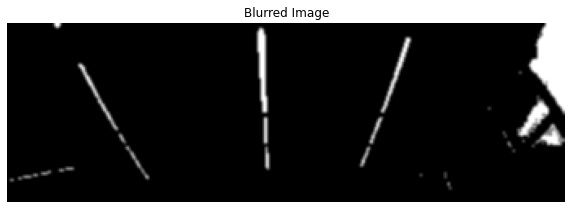

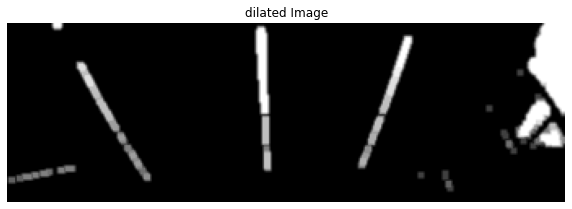

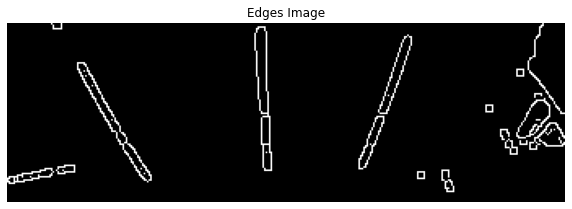

Found line with length 84.2140130857092 and angle 85.91438322002513
Found line with length 88.05112151472007 and angle 88.04749095060039
Discarding line with length 75.8023746329889 and angle 59.03624346792648
Discarding line with length 64.25729530566937 and angle 69.0265065786792
Discarding line with length 85.70297544426332 and angle 70.93080646265187
Discarding line with length 107.18675291284833 and angle 59.12791663691969
Discarding line with length 83.2946576918352 and angle 4.820766078092657
Discarding line with length 76.10519036176179 and angle 3.0127875041833403


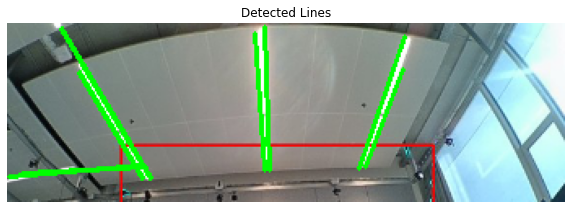

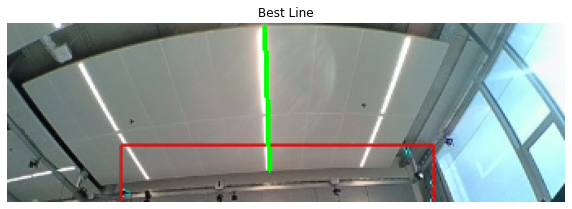

Old action: (0.2, 0.5) -> New action: (0.2, 0.49457636375166775)


In [135]:
class LineFollowing:
    def __init__(self, debug=0):
        self.debug = debug
        self.declare_parameters(
            namespace='',
            parameters=[
                ('binary_threshold', 240),
                ('canny_lower', 100),
                ('canny_upper', 150),
                ('linear_speed', 0.2),
                ('angular_speed', 0.5)
            ]
        )

    def declare_parameters(self, namespace, parameters):
        self.params = dict()
        for param in parameters:
            self.params[param[0]] = param[1]
    
    def get_parameters(self, param_name):
        return self.params[param_name]

    def convert_to_cv2_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
        
    def crop_to_bottom_roi(self, img, roi_height_ratio=0.3):
        height, width = img.shape[:2]
        cropped_img = img[int(height * (1 - roi_height_ratio)):, :]
        return cropped_img

    def crop_to_top_roi(self, img, roi_height_ratio=0.5):
        height, width = img.shape[:2]
        cropped_img = img[:int(height * roi_height_ratio), :]
        return cropped_img

    def convert_to_gray(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return gray
    
    def binarize_image(self, img):
        _, binary = cv2.threshold(img, self.get_parameters('binary_threshold'), 255, cv2.THRESH_BINARY)
        return binary
    
    def canny_edge_detection(self, img):
        edges = cv2.Canny(img, self.get_parameters('canny_lower'), self.get_parameters('canny_upper'))
        return edges
    
    def hough_transform(self, img):
        lines = cv2.HoughLinesP(
            img,
            1,  # rho
            np.pi/180,  # theta 
            30,  # threshold
            minLineLength=40, 
            maxLineGap=50
        )
        return lines 
    
    def get_best_line(self, lines):
        # alternatively, we can score all of them and choose the best one
        best_line = None
        max_length = 0
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            angle = abs(np.degrees(np.arctan2(y2 - y1, x2 - x1)))
            if 75 <= angle <= 105 and length > max_length:
                max_length = length
                best_line = line
                if self.debug > 1: print(f"Found line with length {length} and angle {angle}")
            elif self.debug > 1:
                print(f"Discarding line with length {length} and angle {angle}")
        return best_line

    def action(self, best_line):
        cur_lin = self.get_parameters('linear_speed')
        cur_ang = self.get_parameters('angular_speed')

        if best_line is None:
            # slightly decrease the linear speed
            return 0.98*cur_lin, cur_ang
        
        x1, y1, x2, y2 = best_line[0]
        line_angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) / 180
        new_ang = 0.5 * (line_angle + cur_ang)
        action = (cur_lin, new_ang)
        if self.debug > 0: print(f"Old action: {(cur_lin, cur_ang)} -> New action: {action}")
        return action
    
    def display_image(self, title, image):
        plt.figure(figsize=(10, 10))
        plt.title(title)
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.show()

    def draw_lines(self, img, lines):
        # Create a copy of the image to draw lines on
        line_image = img.copy()
        
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green lines
                
        return line_image
    
    def pipeline(self, img):
        # image loading
        img = cv2.imread(img)
        img = self.convert_to_cv2_image(img)

        if self.debug > 3: self.display_image('Original Image', img)

        # crop image to roi to avoid having to deal with unimportant lines
        img = self.crop_to_top_roi(img)
        img_cropped = img.copy()
        if self.debug > 3: self.display_image('Cropped Image', img)

        # binarize
        img = self.convert_to_gray(img)
        img = self.binarize_image(img)
        if self.debug > 3: self.display_image('Binary Image', img)

        # blur and dilate to remove noise and fill gaps in the lines
        img = cv2.GaussianBlur(img, (3, 3), 0)
        if self.debug > 3: self.display_image('Blurred Image', img)
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
        if self.debug > 3: self.display_image('dilated Image', img)

        # edge detection
        edges = self.canny_edge_detection(img)
        if self.debug > 3: self.display_image('Edges Image', edges)

        # hough transform
        lines = self.hough_transform(edges)

        # get the best line
        best_line = self.get_best_line(lines)

        if self.debug > 3 and best_line is not None:
            result = self.draw_lines(img_cropped, lines)
            self.display_image('Detected Lines', result)

            result = self.draw_lines(img_cropped, [best_line])
            self.display_image('Best Line', result)

        # determine the best line and action
        action = self.action(best_line)

        # return action
    
l = LineFollowing()
l.debug = 4
# for i in range(0, 260):
    # l.pipeline("images/frame%d.jpg" % i)
# l.pipeline("images/frame47.jpg")
l.pipeline("images/image.png")